In [26]:
#@title <font color='Blue'>**Overheads**</font>

# Author: Yu-Man Tam
# Last updated: 5/23/2020

# Reference: Deep Hedging (2019, Quantitative Finance) by Buehler et al.
# https://www.tandfonline.com/doi/abs/10.1080/14697688.2019.1571683

!apt-get update --fix-missing
#!apt-get -qq install -y libquantlib0-dev
!pip -q install QuantLib tqdm

# Import custom modules from github
!rm -rf deep-hedging
!git clone https://github.com/YuMan-Tam/deep-hedging

import sys, os
sys.path.insert(0, os.getcwd() + "/deep-hedging")

from IPython.display import clear_output

import numpy as np
import QuantLib as ql
import tensorflow as tf
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
                                            ReduceLROnPlateau
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from stochastic_processes import BlackScholesProcess
from instruments import EuropeanCall
from deep_hedging import Deep_Hedging_Model, Delta_SubModel
from loss_metrics import Entropy
from utilities import train_test_split

!pip install yfinance
!pip install pandas_datareader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override() 

%load_ext autoreload

clear_output()
print("\nFinish installing and importing all necessary libraries!")


Finish installing and importing all necessary libraries!


In [94]:
#@title <font color='Blue'>**User Inputs**</font>

# Geometric Brownian Motion.
N = 30 # Number of time steps (in days)

S0 = 100.0 # Stock price at time = 0
sigma = 0.2 # Implied volatility
risk_free = 0.0 # Risk-free rate
dividend = 0.0 # Continuous dividend yield

Ktrain = 1240 # Size of training sample.
Ktest_ratio = 0.2 # Fraction of training sample as testing sample.

# European call option (short).
strike = S0
payoff_func = lambda x: -np.maximum(x - strike, 0.0)
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N

# Day convention.
day_count = ql.Actual365Fixed() # Actual/Actual (ISDA)

# Proportional transaction cost.
epsilon = 0.0

# Information set (in string)
# Choose from: S, log_S, normalized_log_S (by S0)
information_set = "normalized_log_S"

# Loss function
# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha 
# loss_type = "Entropy" -> loss_param = lambda 

loss_type = "Entropy"
loss_param = 1.0

# Neural network (NN) structure
m = 15 # Number of neurons in each hidden layer.
d = 1 # Number of hidden layers (Note including input nor output layer)         

# Neural network training parameters
lr = 1e-2 # Learning rate
batch_size=256 # Batch size
epochs=50 # Number of epochs

# Other parameters
use_batch_norm = False
kernel_initializer = "he_uniform"

activation_dense = "leaky_relu"
activation_output = "sigmoid"
final_period_cost = False

delta_constraint = (0.0, 1.0)
share_stretegy_across_time = False
cost_structure = "proportional"

# Other control flags for development purpose.
mc_simulator = "QuantLib" # "QuantLib" or "Numpy"

# Total obs = Training + Testing
nobs = int(Ktrain*(1+Ktest_ratio)) 
		
# Length of one time-step (as fraction of a year).
dt = day_count.yearFraction(calculation_date,calculation_date + 1) 
maturity = N*dt # Maturities (in the unit of a year)


In [108]:
#@title <font color='Blue'>**Prepare real data to be fed into the deep hedging algorithm.**</font>

name = '005930.KS' #삼성전자
ticker = yf.Ticker(name)
df = ticker.history(interval='1d', period='6y', auto_adjust=False)

S = df["Close"][:1240].to_numpy()
S = np.reshape(S, (-1,31))
S0 = S[0]

payoff_T = payoff_func(S[:,-1]) # Payoff of the call option

trade_set =  np.stack((S),axis=1) # Trading set

if information_set is "S":
  I =  np.stack((S),axis=1) # Information set
elif information_set is "log_S":
  I =  np.stack((np.log(S)),axis=1)
elif information_set is "normalized_log_S":
  I =  np.stack((np.log(S/S0)),axis=1)

# Structure of xtrain:
#   1) Trade set: [S]
#   2) Information set: [S] 
#   3) payoff (dim = 1)
x_all = []
for i in range(N+1):
  x_all += [trade_set[i,:,None]]
  if i != N:
    x_all += [I[i,:,None]]
x_all += [payoff_T[:,None]]

# Split the entire sample into a training sample and a testing sample.
test_size = int(Ktrain*Ktest_ratio)
[xtrain, xtest] = train_test_split(x_all, test_size=Ktest_ratio)
[S_train, S_test] = train_test_split([S], test_size=Ktest_ratio)

[option_payoff_train, option_payoff_test] = \
    train_test_split([x_all[-1]], test_size=Ktest_ratio)

clear_output()
print("Finish preparing data!")

Finish preparing data!


In [99]:
#@title <font color='Blue'>**Run the Deep Hedging Algorithm (Simple Network)!**</font>
%autoreload 2

optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model_simple = Deep_Hedging_Model(N=N, d=d+2, m=m, risk_free=risk_free, \
          dt = dt, strategy_type="simple", epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost, delta_constraint = delta_constraint, \
          share_stretegy_across_time = share_stretegy_across_time, \
          cost_structure = cost_structure)
loss = Entropy(model_simple.output,None,loss_param)
model_simple.add_loss(loss)

model_simple.compile(optimizer=optimizer)

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_simple.fit(x=xtrain, batch_size=batch_size, epochs=epochs)

clear_output()

print("Finished running deep hedging algorithm! (Simple Network)")

Finished running deep hedging algorithm! (Simple Network)


In [100]:
#@title <font color='Blue'>**Run the Deep Hedging Algorithm (Recurrent Network)!**</font>
optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model_recurrent = Deep_Hedging_Model(N=N, d=d+2, m=m, risk_free=risk_free, \
          dt = dt, strategy_type="recurrent", epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost)

loss = Entropy(model_recurrent.output,None,loss_param)
model_recurrent.add_loss(loss)

model_recurrent.compile(optimizer=optimizer)

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_recurrent.fit(x=xtrain, batch_size=batch_size, epochs=epochs)

print("Finished running deep hedging algorithm! (Simple Network)")

Epoch 1/50
1/1 [==============================] - 13s 13s/step - loss: inf
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: nan
Epoch 3/50
1/1 [==============================] - 0s 29ms/step - loss: nan
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: nan
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 8/50
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: nan
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: nan
Epoch 11/50
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 12/50
1/1 [==============================] - 0s 28ms/step - loss: nan
Epoch 13/50
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 14/50
1/1 [====

In [109]:
#@title <font color='Blue'>**Results: Option Prices**</font>
call = EuropeanCall()

price_BS = call.get_BS_price(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, \
              day_count = day_count, dt = dt)
delta_BS = call.get_BS_delta(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, 
              day_count = day_count, dt = dt)

PnL_BS =  call.get_BS_PnL(S= S_test[0], \
              payoff= payoff_func(S_test[0][:,-1]), delta=delta_BS, \
              dt= dt, risk_free = risk_free, \
              final_period_cost=final_period_cost, epsilon=epsilon, \
              cost_structure = cost_structure )

risk_neutral_price = \
    -option_payoff_test[0].mean()*np.exp(-risk_free*(N*dt))
nn_simple_price = model_simple.evaluate(xtest, batch_size=test_size, verbose=0)

print("The Black-Scholes model price is %2.3f." % price_BS[0][0])
print("The Risk Neutral price is %2.3f." % risk_neutral_price)
print("The Deep Hedging (with simple network) price is %2.3f." % nn_simple_price)

try:
  nn_recurrent_price = model_recurrent.evaluate(xtest, batch_size=test_size, verbose=0)
  print("The Deep Hedging (with recurrent network) price is %2.3f." % nn_recurrent_price)
except:
  print("No Recurrent model.")


The Black-Scholes model price is 59900.000.
The Risk Neutral price is 78350.000.
The Deep Hedging (with simple network) price is nan.
The Deep Hedging (with recurrent network) price is nan.


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


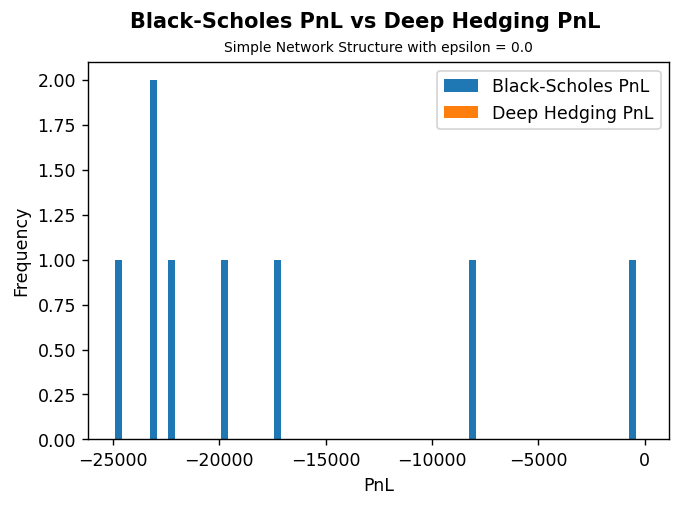

In [110]:
#@title <font color='Blue'>**Results: Black-Scholes PnL vs Deep Hedging PnL**</font>
bar1 = PnL_BS + price_BS[0][0]
bar2 = model_simple(xtest).numpy().squeeze() + price_BS[0][0]

# Plot Black-Scholes PnL and Deep Hedging PnL (with BS_price charged on both).
fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Black-Scholes PnL vs Deep Hedging PnL \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_title("Simple Network Structure with epsilon = " + str(epsilon), \
      fontsize=8)
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
          label=["Black-Scholes PnL", "Deep Hedging PnL"])
ax.legend()
plt.show()

In [111]:
#@title <font color='Blue'>**Results: Black-Scholes Delta vs Deep Hedging Delta.**</font>
for days_from_today in (1,15,29):
  tau = (N-days_from_today)*dt
    
  min_S = S_test[0][:,days_from_today].min()
  max_S = S_test[0][:,days_from_today].max()
  S_range = np.linspace(min_S,max_S,101)

  # Attention: Need to transform it to be consistent with the information set.
  if information_set is "S":
    I_range =  S_range # Information set
  elif information_set is "log_S":
    I_range =  np.log(S_range)
  elif information_set is "normalized_log_S":
    I_range =  np.log(S_range/S0)        
      
  # Compute Black-Scholes delta for S_range.
  # Reference: https://en.wikipedia.org/wiki/Greeks_(finance)
  d1 = (np.log(S_range) - np.log(strike) + \
        (risk_free - dividend + (sigma**2)/2)*tau) \
              / (sigma*np.sqrt(tau))  
                
  model_delta = norm.cdf(d1)*np.exp(-dividend*tau)

  if share_stretegy_across_time is False:
    submodel = Delta_SubModel(model = model_simple, \
                      days_from_today = days_from_today)
  else:
    submodel = Delta_SubModel(model = model_simple, \
                      days_from_today = 0)
    
  nn_delta = submodel(I_range)

  # Create a plot of Black-Scholes delta against deep hedging delta.
  fig_delta = plt.figure(dpi= 125, facecolor='w')
  fig_delta.suptitle("Black-Scholes Delta vs Deep Hedging Delta \n", \
        fontweight="bold")
  ax_delta = fig_delta.add_subplot()
  ax_delta.set_title("Simple Network Structure with " + \
              "t=" + str(days_from_today) + ", " + \
                "epsilon=" + str(epsilon), \
                fontsize=8)
  ax_delta.set_xlabel("Price of the Underlying Asset")
  ax_delta.set_ylabel("Delta")
  ax_delta.plot(S_range, model_delta, label="Black-Scholes Delta")
  ax_delta.scatter(S_range,nn_delta, c="red", s=2, label="Deep Hedging Delta")
  ax_delta.legend()
  plt.show()

ValueError: ignored